# Proyecto final 

In [80]:
import glob
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage
import cv2
from face_detection.pyimagesearch.facedetector import FaceDetector
from skimage.feature import local_binary_pattern

In [81]:
def histogramas_celda(imagen_lbp, n_bins=11):
    hist = np.histogram(imagen_lbp,np.arange(n_bins))
    return hist



from face_detection.pyimagesearch.facedetector import FaceDetector
def ubicacion_rostros_gray(gray_image):
    """
    Función para obtener ubicación de rostro
    Parametros:
        gray_image: Imagen en escala de grises
    Salida:
        faceRects: Coordenadas rostros (x,y,w,h)
    """
    path_detector = 'face_detection/cascades/haarcascade_frontalface_default.xml'


    # find faces in the image
    fd = FaceDetector(path_detector)
    newimage = np.array(gray_image, dtype='uint8')
    
    faceRects = fd.detect(newimage, scaleFactor = 1.1, minNeighbors = 5,minSize = (30, 30)) 

    # loop over the faces and draw a rectangle around each
    number_detections = len(faceRects)
    #print(number_detections)
    if number_detections == 1:      
        #for (x, y, w, h) in faceRects:
        #    recorte = np.array(newimage[y:y+h,x:x+w]) # se crea nuevo espacio en la memoria
        #    cv2.rectangle(newimage, (x, y), (x + w, y + h), (0, 255, 0), 2)   
        return faceRects
    else:
        return np.nan

def histogramas_LBP_TOP(vol1,P,R,metodo):
    """
    Funcion para calcular histograma de una textura dinamica (video) con LBP-TOP
    
    Parametros:
        vol1: frames de dimensione (T,Y,X)
        P: Puntos operador LBP
        R: Radio operador LBP
        metodo: metodo de LBP
    Salida:
        hist_XY, hist_XT, hist_YT: Histogramas de cada plano.
    """
    (T,Y,X) = vol1.shape
    # plano XY
    lbp_XY = local_binary_pattern(vol1[int(T/2),:,:],P,R,metodo)
    histogramas_XY = histogramas_celda(lbp_XY)
    hist_XY = histogramas_XY[0]/sum(histogramas_XY[0])
    
    # XT 
    lbp_XT = local_binary_pattern(vol1[:,int(Y/2),:],P,R,metodo)
    histogramas_XT = histogramas_celda(lbp_XT)
    hist_XT = histogramas_XT[0]/sum(histogramas_XT[0])
    
    lbp_YT = local_binary_pattern(vol1[:,:,int(X/2)],P,R,metodo)
    histogramas_YT = histogramas_celda(lbp_YT)
    hist_YT = histogramas_YT[0]/sum(histogramas_YT[0])
    
    return hist_XY, hist_XT, hist_YT


def recortar_volumen_normalizar(vol1):
    """
    Se detecta en el frame central las imagenes del rostro. Se recorta todo el volumen
    con esas dimensiones. Luego se realiza un reshape a 64x64
    """

    (T,Y,X) = vol1.shape
    frame_central = vol1[int(T/2),:,:]
    ubicacion = ubicacion_rostros_gray(frame_central)
    #print(type(ubicacion))
    if type(ubicacion) == type(np.nan):
        print('No se detecta rostro')
        return np.nan
    else:
        (x, y, w, h) = ubicacion[0][0],ubicacion[0][1],ubicacion[0][2],ubicacion[0][3]
        vol_r = vol1[:,y:y+h,x:x+w]#volumen recortado
        vol_resize = np.zeros((T,64,64))
        for i in range(0,T):
            vol_resize[i] =  cv2.resize(vol_r[i],(64,64),interpolation = cv2.INTER_AREA)
        
    return vol_resize

def dimensiones_video(path_video):
    cap = cv2.VideoCapture(path_video)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    print('Las dimensiones del video son: ',(height,width))
    
def resize_gray(path_video,width,height, ataque=False):
    """
    Se obtiene el video en un np array 3D redimensionado y rotado (T,height/5,widht/5). 
    """
    cap = cv2.VideoCapture(path_video)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(length)
    gray_array = np.zeros((length,int(width/5),int(height/5)))
    dim = (int(width/5),int(height/5))
    success,frame = cap.read()
    c = 0
    while success:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if ataque == False:
            gray_array[c]= scipy.ndimage.rotate(cv2.resize(gray, dim, interpolation = cv2.INTER_AREA),90)
        else:
            # La imagen fue grabada con la camara trasera lo que cambia la orientacion de grabacion.
            gray_array[c]= scipy.ndimage.rotate(cv2.resize(gray, dim, interpolation = cv2.INTER_AREA),-90)
        c += 1
        success, frame = cap.read()

    cap.release()
    return gray_array

def plot_imagen(gray):
    imgplot = plt.imshow(gray, cmap='gray')

def graficar_bb(ub, imagen):
    x, y, w, h = ub[0][0], ub[0][1], ub[0][2], ub[0][3]
    test = np.array(imagen)
    cv2.rectangle(test, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plot_imagen(test)
    
    

def vector_caracteristicas(gray_video,P,R,metodo):
    """
    Retorna el vector de caracteristicas de un video. 
    """
    video_norm = recortar_volumen_normalizar(gray_video)
    if type(video_norm) != type(np.nan):        
        histogramas = histogramas_LBP_TOP(video_norm,P,R,metodo)
        hist = np.reshape(np.concatenate((histogramas[0],histogramas[1],histogramas[2])),(1,-1))
        hay_hist = True
    else:
        hay_hist = False
        hist = 0
        
        
    return hay_hist, hist




# 1. Experimentos
## 1.1 Detector de rostros

In [82]:
# lista de videos 
path_videos_r = glob.glob("./data/videos/*.mp4") # accesos reales
print('Cantidad de videos accesos reales:',len(path_videos_r))

path_videos_a = glob.glob("./data/VideosAtaques/*.mp4") # ataques
print('Cantidad de videos ataques:',len(path_videos_a))

Cantidad de videos accesos reales: 7
Cantidad de videos ataques: 9


### 1.1.1 Acceso real

In [98]:
ej1 = path_videos_r[5] # ejemplo 1
width = 1920
height = 1080
ej1_gray = resize_gray(ej1,width,height) # video en frames

print('Dimensiones de ejemplo 1:',ej1_gray.shape) # el video se reescala a 1/5 de su tamaño original.

598
Dimensiones de ejemplo 1: (598, 384, 216)


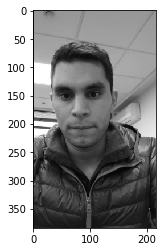

In [104]:
# primer frame del video en escala de grises
plot_imagen(ej1_gray[40])

In [105]:
ub1 = ubicacion_rostros_gray(ej1_gray[0]) # ubicacion rostro
print('La coordenadas de la ubicación del rostros (x, y, w, h):',ub1)

La coordenadas de la ubicación del rostros (x, y, w, h): [[ 39  92 149 149]]


Bounding box de rostro detectado


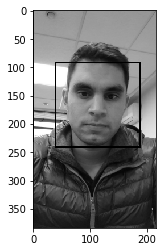

In [106]:
print('Bounding box de rostro detectado')
graficar_bb(ub1, ej1_gray[0])


### 1.1.2 Ataque

In [107]:
ej2 = path_videos_a[5] # video de ataque
ej2_gray = resize_gray(ej2,width,height, ataque=True) # video en frames

print('Dimensiones de ejemplo 1:',ej2_gray.shape) # el video se reescala a 1/5 de su tamaño original.

623
Dimensiones de ejemplo 1: (623, 384, 216)


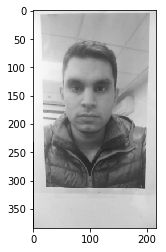

In [113]:
# primer frame del video en escala de grises
plot_imagen(ej2_gray[30])

In [109]:
ub2 = ubicacion_rostros_gray(ej2_gray[0]) # ubicacion rostro
print('La coordenadas de la ubicación del rostros (x, y, w, h):',ub2)

La coordenadas de la ubicación del rostros (x, y, w, h): [[ 29  73 133 133]]


Bounding box de rostro detectado


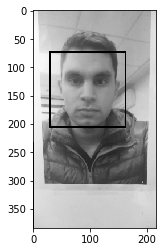

In [110]:
print('Bounding box de rostro detectado')
graficar_bb(ub2, ej2_gray[0])


## 1.2 Histogramas
### 1.2.1 Acceso real

La dimensionnes del vide normalizado son: (598, 64, 64)


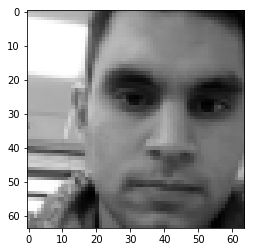

In [114]:
ej1_norm = recortar_volumen_normalizar(ej1_gray)
print('La dimensionnes del vide normalizado son:',ej1_norm.shape)
plot_imagen(ej1_norm[0])

In [115]:
P = 8
R = 1
metodo = 'uniform'
histogramas_ej1 = histogramas_LBP_TOP(ej1_norm,P,R,metodo)
print(histogramas_ej1)

hist_ej1 = np.reshape(np.concatenate((histogramas_ej1[0],histogramas_ej1[1],histogramas_ej1[2])),(1,-1))
print('Las dimension del histograma concatenado es: ', hist_ej1.shape)



(array([0.03198242, 0.05664062, 0.06298828, 0.17041016, 0.35375977,
       0.13549805, 0.04614258, 0.05395508, 0.02832031, 0.06030273]), array([0.03668478, 0.06534804, 0.01690531, 0.14914298, 0.3841712 ,
       0.16947115, 0.01486727, 0.05685619, 0.03456835, 0.07198474]), array([0.03903637, 0.06963315, 0.02163462, 0.14867266, 0.3822638 ,
       0.14804557, 0.01714047, 0.06344064, 0.03621446, 0.07391827]))
Las dimension del histograma concatenado es:  (1, 30)


### 1.2.2 Ataque

La dimensionnes del vide normalizado son: (623, 64, 64)


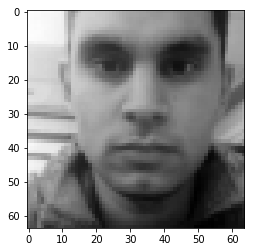

In [116]:
ej2_norm = recortar_volumen_normalizar(ej2_gray)
print('La dimensionnes del vide normalizado son:',ej2_norm.shape)
plot_imagen(ej2_norm[0])

In [117]:
histogramas_ej2 = histogramas_LBP_TOP(ej2_norm,P,R,metodo)
print(histogramas_ej2)

hist_ej2 = np.reshape(np.concatenate((histogramas_ej2[0],histogramas_ej2[1],histogramas_ej2[2])),(1,-11))
print('Las dimension del histograma concatenado es: ', hist_ej2.shape)


(array([0.02539062, 0.04516602, 0.07080078, 0.17504883, 0.38476562,
       0.14404297, 0.04516602, 0.04174805, 0.02197266, 0.04589844]), array([0.03842295, 0.05605437, 0.03335674, 0.14744683, 0.39022372,
       0.15707765, 0.02916834, 0.05377207, 0.02964486, 0.06483246]), array([0.04083066, 0.066563  , 0.03195225, 0.12908808, 0.40464486,
       0.12627909, 0.02713684, 0.05891352, 0.03809691, 0.07649478]))
Las dimension del histograma concatenado es:  (1, 30)


# 2. Base de datos

Se generan los conjuntos de datos. De cada imagen se extraen los histogramas en los planos XY, XT e YT y son concatenados para formar un vector de características por imagen. El vector de características tiene dimesiones (1,30), dado que se utilizan 10 bins. 

## 2.1 Acceso real

In [16]:
base_real = np.empty([100, 1,30]) # vector de caracteristicas acceso real. Dimension (1,60)
k = 0
for i in range(len(path_videos_r)):
    path_video = path_videos_r[i] # path video
    gray_video = resize_gray(path_video,1920,1080, ataque = False)
    n = len(gray_video)
    n_batch = int(n/75) # videos de 75 frame
    for j in range(n_batch):
        frames = gray_video[75*(j):75*(j+1)]
        hay_hist, hist = vector_caracteristicas(frames,P,R,metodo)
        if hay_hist:
            base_real[k] = hist
            k += 1
print('Numero de muestras:', k)

961
622
1225
634
No se detecta rostro
874
598
1070
Numero de muestras: 75


In [18]:
#np.savetxt("accesos_reales.csv", np.reshape(base_real[0:k],(-1,30)), delimiter=",")

In [19]:
base_ataque = np.empty([100, 1,30]) # vector de caracteristicas acceso real. Dimension (1,60)
k = 0
for i in range(len(path_videos_a)):
    path_video = path_videos_a[i] # path video
    gray_video = resize_gray(path_video,1920,1080, ataque = True)
    n = len(gray_video)
    n_batch = int(n/75) # videos de 75 frame
    for j in range(n_batch):
        frames = gray_video[75*(j):75*(j+1)]
        hay_hist, hist = vector_caracteristicas(frames,P,R,metodo)
        if hay_hist:
            base_ataque[k] = hist
            k += 1
print('Numero de muestras:', k)

607
758
624
596
596
623
751
593
600
No se detecta rostro
Numero de muestras: 72


In [ ]:
#np.savetxt("ataques.csv", np.reshape(base_ataque[0:k],(-1,30)), delimiter=",")

## 3. Clasificador

In [118]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm


base_reales = np.genfromtxt('accesos_reales.csv', delimiter=',')
base_ataques = np.genfromtxt('ataques.csv', delimiter=',')
base = np.concatenate((base_reales,base_ataques), axis = 0)

base_reales_clase = np.zeros((75,1)) # muestras reales
base_ataques_clase = np.ones((72,1)) # muestras ataques 
base_y = np.concatenate((base_reales_clase,base_ataques_clase), axis = 0)
print('Dimesion vector clases:', base_y.shape)



Dimesion vector clases: (147, 1)


In [119]:
clasificadores = []
C = [0.1, 1, 10, 100, 1000]

gamma = [0.001, 0.1, 1, 10, 100, 1000]

for c in C:
    for g in gamma:
        clf = svm.SVC(kernel='rbf', C=c, gamma=g)
        scores = cross_val_score(clf, base, np.ravel(base_y), cv=3)
        clasificadores.append([clf, np.mean(scores)])
        print(np.mean(scores))

0.5102040816326531
0.5102040816326531
0.5102040816326531
0.6870748299319729
0.7619047619047619
0.5102040816326531
0.5102040816326531
0.5102040816326531
0.7482993197278912
0.7823129251700681
0.7210884353741497
0.7210884353741497
0.5102040816326531
0.7551020408163266
0.7755102040816326
0.7891156462585034
0.8231292517006802
0.7210884353741497
0.5102040816326531
0.7755102040816326
0.8435374149659864
0.8843537414965986
0.8231292517006802
0.7210884353741497
0.7551020408163266
0.8503401360544217
0.9115646258503401
0.8639455782312925
0.8231292517006802
0.7210884353741497


In [120]:
clasificadores[-4]

[SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
     probability=False, random_state=None, shrinking=True, tol=0.001,
     verbose=False), 0.9115646258503401]

In [121]:
X_train, X_test, y_train, y_test = train_test_split(base, base_y, test_size=0.4, random_state=0)
X_train.shape, y_train.shape

((88, 30), (88, 1))

In [122]:
muestras_train = np.zeros([2])
muestras_test = np.zeros([2])

In [123]:
for i in range(len(y_train)):
    muestras_train[int(y_train[i])] +=1
    
for i in range(len(y_test)):
    muestras_test[int(y_test[i])] +=1

In [124]:
print(muestras_train)

[46. 42.]


In [125]:
print(muestras_test)

[29. 30.]


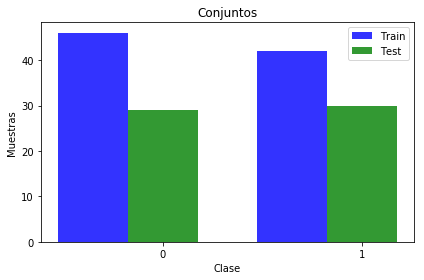

In [126]:
import matplotlib.pyplot as plt
n_groups = 2

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, muestras_train, bar_width,
alpha=opacity,
color='b',
label='Train')

rects2 = plt.bar(index + bar_width, muestras_test, bar_width,
alpha=opacity,
color='g',
label='Test')

plt.xlabel('Clase')
plt.ylabel('Muestras')
plt.title('Conjuntos')
plt.xticks(index + bar_width, ('0','1'))
plt.legend()

plt.tight_layout()
plt.show()

In [127]:
clf = svm.SVC(kernel='rbf', C=1000, gamma = 1).fit(X_train, y_train.ravel())

In [128]:
clf.score(X_test, y_test)

0.9661016949152542

In [129]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()

In [130]:
def metricas_biometricas(FN,FP,TP,TN):
    FAR = FN/TN
    FRR = FP/TP
    HTER = (FAR+FRR)/2
    return FAR, FRR, HTER

In [131]:
FAR, FRR, HTER = metricas_biometricas(fn,fp,tp,tn)

In [132]:
print(FAR)

0.03571428571428571


In [133]:
print(FRR)

0.034482758620689655


In [134]:
print(HTER)

0.035098522167487683


In [70]:
fp

1